# Extracting and and saving image features using different models

In [2]:
import pandas as pd 
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm

#initialization code required to make tensorflow work on my systemabs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
print(tf.__version__)

2.4.1


In [266]:
data_dir = 'initial_sample'
dir_path = os.path.join(r'data',data_dir)
data_df_path = os.path.join(dir_path,'sent_added')
images_dir_path = os.path.join(dir_path,'images')

In [267]:
##Load meta_data with image path from root

data_df = pd.read_csv(data_df_path)

In [268]:
image_paths = data_df['image_path'].apply(lambda x: os.path.join(os.getcwd(),x)).values


In [269]:
image_paths

array(['C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\0.png',
       'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\1.png',
       'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\2.png',
       ...,
       'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\9627.png',
       'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\9628.png',
       'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\9629.png'],
      dtype=object)

In [270]:
print(len(image_paths), len(data_df))

9296 9296


In [271]:
#check that the number of images in the dataframe matches the number of image files in our images directory
image_files = os.listdir(images_dir_path)
print(len(image_files))

9296


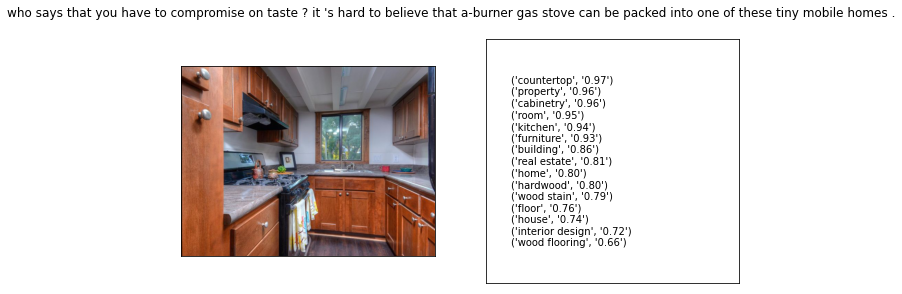

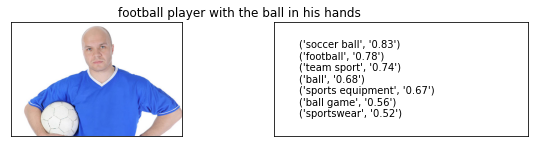

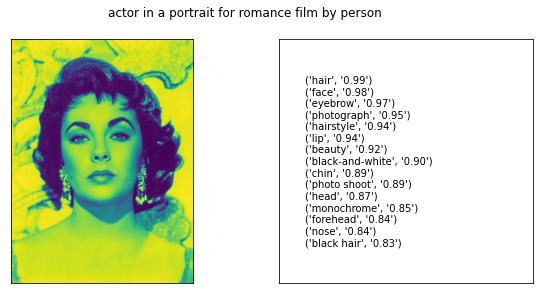

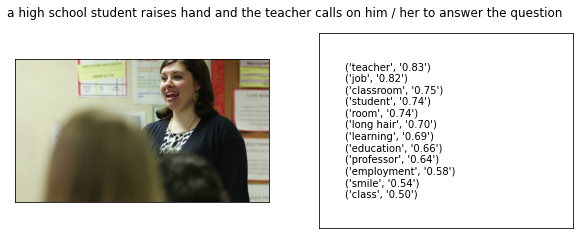

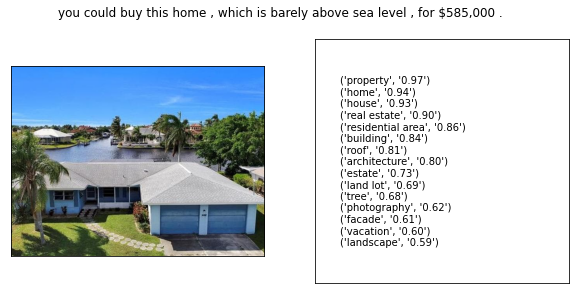

In [272]:
#display some images and captions to make sure the paths are correct
from utils import display_samples

display_samples(data_df)

## InceptionV3 pretrained model embeddings. 

Insipration from [this](https://www.tensorflow.org/tutorials/text/image_captioning) tutorial

In [74]:
#we define the pretrained model we are going to use. The weights are pretrained with image net and we only load evrything up to the last layer
def init_inception_v3_model():
    """
    Returns a pretrained inception V3 model without final layer to use to output embeddings
    """
    embeddings_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    input_layer = embeddings_model.input
    output_layer = embeddings_model.layers[-1].output
    inception_v3_feature_extractor = tf.keras.Model(input_layer,output_layer)
    return inception_v3_feature_extractor

In [94]:
#we need this helper function to put into the preprocessing pipeline
def load_image_for_inception_v3(image_path):
    """
    Given absolute path to the image, load it.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    #this is the input size InceptionV3 takes in
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [76]:
#os.chdir(cwd)
#cwd = os.getcwd()
print(os.getcwd())

C:\Users\apra\Desktop\SPRING 2021\DS 4400\ML1_Final_Proj


In [77]:
def embed_images_with_inception_v3(image_paths, outpath):
    """
    embeds the images in the paths of the given dataframe in the given path into inception v3 embeddings
    and saves them in a directory with the given name. 
    """
    #save current directory
    cwd = os.getcwd()
    #load and initialize the pretrained model
    
    inception_v3_feature_extractor = init_inception_v3_model()
    

    #we use this data pipeline from tensorflow
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    #this runs load_image on every image in the dataset in a batched manner
    #according to some research an RTX 20260 might work well with a batch size of 32, can be tuned furtherabs
    dataset = dataset.map(load_image_for_inception_v3, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

    #change directory to directory we want to save embeddings in

    for image, image_path in tqdm(dataset):
        batch_embeddings = inception_v3_feature_extractor(image)
        #reshape batch embeddings to one embedding per image
        batch_embeddings = tf.reshape(batch_embeddings, 
                                     (batch_embeddings.shape[0], -1, batch_embeddings.shape[3]))

        for batch_embedding, path in zip(batch_embeddings,image_path):
            image_num = os.path.basename(path.numpy().decode("utf-8"))
            #save numpy embedding to current directory
            os.chdir(outpath)
            np.save(image_num,batch_embedding.numpy())
            os.chdir(cwd)
    #change back to cwd
    os.chdir(cwd)


In [20]:
# #we will first attempt the pipeline on a few hundred samples to see if everything is fine
# num_samples = 100
# image_paths = np.random.choice(image_paths, size=num_samples, replace = False )

In [16]:


embeddings_dir_name = 'inception_v3_embeddings'
#create directory we want to store embeddings in and change to that directory
inception_v3_embeddings_directory = os.path.join(dir_path, embeddings_dir_name)
os.mkdir(inception_v3_embeddings_directory)
print(inception_v3_embeddings_directory)


data\30k_sample\inception_v3_embeddings


In [30]:
print(inception_v3_embeddings_directory)
print(image_paths)
print(os.getcwd())

data\30k_sample\inception_v3_embeddings
['C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\30k_sample\\images\\552309.png'
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\30k_sample\\images\\225955.png'
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\30k_sample\\images\\1415488.png'
 ...
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\30k_sample\\images\\1098702.png'
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\30k_sample\\images\\790196.png'
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\30k_sample\\images\\1435814.png']
C:\Users\apra\Desktop\SPRING 2021\DS 4400\ML1_Final_Proj


In [22]:
embed_images_with_inception_v3(image_paths, inception_v3_embeddings_directory)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 936/936 [05:16<00:00,  2.95it/s]


## Inception-Resnet-v2 pretrained model embeddings

According to [Google's Official Paper](https://www.aclweb.org/anthology/P18-1238.pdf) for this dataset, this model architecture is the best for image feature architecture. Here, we will write methods to exctract embeddings using this architecture with Imagenet pretrained weights

In [107]:
#we define the pretrained model we are going to use. The weights are pretrained with image net and we only load evrything up to the last layer
def init_inception_resnet_v2_model():
    """
    Returns a pretrained inception-resnet-v2  model without final layer to use to output embeddings
    """
    embeddings_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet')
    input_layer = embeddings_model.input
    output_layer = embeddings_model.layers[-1].output
    inception_resnet_v2_feature_extractor = tf.keras.Model(input_layer,output_layer)
    return inception_resnet_v2_feature_extractor

In [108]:
#we need this helper function to put into the preprocessing pipeline
def load_image_for_inception_resnet_v2(image_path):
    """
    Given absolute path to the image, load it.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    #this is the input size InceptionV3 takes in
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
    return img, image_path

In [109]:
def embed_images_with_inception_resnet_v2(image_paths, outpath):
    """
    embeds the images in the paths of the given dataframe in the given path into inception v3 embeddings
    and saves them in a directory with the given name. 
    """
    #save current directory
    cwd = os.getcwd()
    #load and initialize the pretrained model
    
    inception_resnet_v2_feature_extractor = init_inception_resnet_v2_model()
    

    #we use this data pipeline from tensorflow
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    #this runs load_image on every image in the dataset in a batched manner
    #according to some research an RTX 20260 might work well with a batch size of 32, can be tuned furtherabs
    dataset = dataset.map(load_image_for_inception_resnet_v2, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

    #change directory to directory we want to save embeddings in

    for image, image_path in tqdm(dataset):
        batch_embeddings = inception_resnet_v2_feature_extractor(image)
        #reshape batch embeddings to one embedding per image
        batch_embeddings = tf.reshape(batch_embeddings, 
                                     (batch_embeddings.shape[0], -1, batch_embeddings.shape[3]))

        for batch_embedding, path in zip(batch_embeddings,image_path):
            image_num = os.path.basename(path.numpy().decode("utf-8"))
            #save numpy embedding to current directory
            os.chdir(outpath)
            np.save(image_num,batch_embedding.numpy())
            os.chdir(cwd)
    #change back to cwd
    os.chdir(cwd)

In [50]:
embeddings_dir_name = 'inception_resnet_v2_embeddings'
#create directory we want to store embeddings in and change to that directory
inception_resnet_v2_embeddings_directory = os.path.join(dir_path, embeddings_dir_name)
os.mkdir(inception_resnet_v2_embeddings_directory)
print(inception_resnet_v2_embeddings_directory)

data\initial_sample\inception_resnet_v2_embeddings


In [51]:
print(inception_resnet_v2_embeddings_directory)
print(image_paths)
print(os.getcwd())

data\initial_sample\inception_resnet_v2_embeddings
['C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\0.png'
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\1.png'
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\2.png'
 ...
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\9627.png'
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\9628.png'
 'C:\\Users\\apra\\Desktop\\SPRING 2021\\DS 4400\\ML1_Final_Proj\\data\\initial_sample\\images\\9629.png']
C:\Users\apra\Desktop\SPRING 2021\DS 4400\ML1_Final_Proj


In [52]:
embed_images_with_inception_resnet_v2(image_paths, inception_resnet_v2_embeddings_directory)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [01:50<00:00,  2.64it/s]


## Effect of the preprocessing methods to 

Both feature extraction methods have an input size of 299x299. But as we have seen in our exploration, our images have varying sizes and aspect ratios. I worry specifically about images that might be stretched in a way that destroys the semantic information in them.Lets have a deeper look at what the preprocessing methods are doing to the images and whether we are able to preserve multiple objects/their relative locations for images of different sizes and aspect ratios

### Papers:

- [fully convolutional networks for semantic segmentation](https://arxiv.org/pdf/1411.4038.pdf

Lets sample some images and display them before and after preprocessing for both pretrained models

In [68]:
import matplotlib.pyplot as plt


In [57]:
print(os.getcwd())

C:\Users\apra\Desktop\SPRING 2021\DS 4400\ML1_Final_Proj


### Inception_v3

In [389]:
#sample some images
sample_images = data_df[data_df['aspect_ratio']> 1.7].sample(n = 1, random_state=00)

In [390]:
from tensorflow.keras.preprocessing import image
sample_image_paths = sample_images.image_path.values


In [391]:
example_image_path = sample_image_paths[0]
img = tf.io.read_file(example_image_path)
img = tf.image.decode_png(img, channels=3)


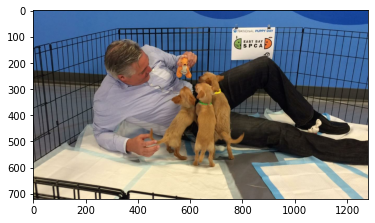

In [392]:
plt.imshow(img)

In [393]:
#we need this helper function to put into the preprocessing pipeline
def load_image_for_inception_v3(image_path):
    """
    Given absolute path to the image, load it.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    #this is the input size InceptionV3 takes in
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [394]:
processed_img, path = load_image_for_inception_v3(example_image_path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


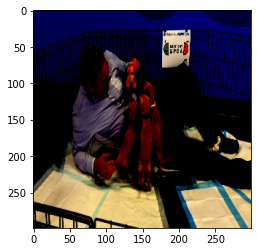

In [395]:
plt.imshow(processed_img)

In [396]:
#we need this helper function to put into the preprocessing pipeline
def load_image_for_inception_v3(image_path):
    """
    Given absolute path to the image, load it.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    #this is the input size InceptionV3 takes in
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Inception-Resnet-v2

In [397]:
processed_img, path = load_image_for_inception_resnet_v2(example_image_path)


In [398]:
print(np.min(processed_img))

-1.0


In [399]:
#perhaps normalizing shows features?
processed_img = tf.keras.utils.normalize(
    processed_img, axis=-1, order=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


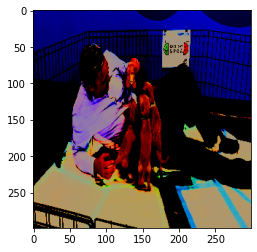

In [400]:
plt.imshow(processed_img)

### k-nearest interpolation

In [401]:
import cv2 


In [402]:
#lets try some tweaks
def load_image_for_inception_v3_alter(image_path):
    """
    Given absolute path to the image, load it.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3).numpy()
    #this is the input size InceptionV3 takes in
    resized_image = cv2.resize(img, (299, 299), 
                           interpolation=cv2.INTER_NEAREST)
    resized_image = tf.keras.applications.inception_v3.preprocess_input(resized_image)
    return resized_image, image_path

In [403]:
processed_img, path = load_image_for_inception_v3_alter(example_image_path)


In [406]:
#perhaps normalizing shows features?
processed_img = tf.keras.utils.normalize(
    processed_img, axis=-1, order=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


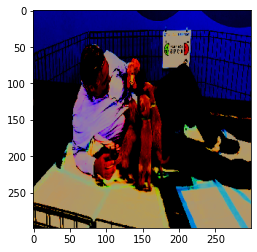

In [407]:
plt.imshow(processed_img)

Looks quiet similar either way, but we can try subbing in different extraction methods to see if there is a difference in model accuracy

## Appendix: dropping rows in metadata for cells that do not exist and saving

In [41]:
meta_df = data_df ###FULL PREPPED META_DATA DF###
meta_data_path = data_df_path ##PATH TO PREPPED META DATA DF #

print(len(data_df))
print(meta_data_path)
print(dir_path)
print(os.getcwd())

29928
data\30k_sample\prepped_meta
data\30k_sample
C:\Users\apra\Desktop\SPRING 2021\DS 4400\ML1_Final_Proj


In [37]:
def clean_images_with_global_index(meta_data_df, dir_path, bad_image_indices):
    """
    Takes in a dataframe with metadata about images and the path of the directory storing the images and 
    their metadata as well as list of global_index iof images that are have been 
    deemed bad or corrupt and deletes the images (if they exist) and the corresponding rows from the given dataframe and saves the updated
    meta_data to the same path as the old one. Finally, loads the updated metadataframe and prints its length along with the 
    length of images in the images directory of this dataset to verify they are the same. 
    """
    meta_path = os.path.join(dir_path, 'prepped_meta')
    images_dir_path = os.path.join( dir_path, 'images')
    
    for global_index in bad_image_indices:
        img_path = os.path.join(images_dir_path, global_index + str('.png'))
        if(os.path.exists(img_path)):
            os.remove(img_path)
        meta_data_df.drop(meta_data_df[meta_data_df['global_index']==int(global_index)].index, axis='index',errors='ignore', inplace=True)
        
    #finally, save the updated df in the same path as the old one
    meta_data_df.to_csv(meta_path, index=False)
    
    #load and verify
    meta_df = pd.read_csv(meta_path)
    images = os.listdir(images_dir_path)
    print(len(meta_df))
    print(len(images))
    
        

In [36]:
#remove_images_that_dont_exist(dir_path)

dropped 284 677089
dropped 456 307506
dropped 1097 1995824
dropped 1250 997701
dropped 1422 1050914
dropped 2874 546662
dropped 3159 918174
dropped 3629 580860
dropped 3779 1616417
dropped 3891 1672676
dropped 5337 1773762
dropped 5575 1682068
dropped 7295 505796
dropped 7641 866580
dropped 8124 992325
dropped 8316 1267465
dropped 8456 774275
dropped 10738 1519129
dropped 10862 315368
dropped 14860 22918
dropped 15600 1580546
dropped 17001 2006884
dropped 17219 348651
dropped 17390 611003
dropped 17763 386090
dropped 18017 1686261
dropped 18188 1110904
dropped 19952 1547743
dropped 20375 890531
dropped 20416 1922603
dropped 21128 1386248
dropped 21408 999540
dropped 22551 350035
dropped 24097 1198135
dropped 25849 1211947
dropped 25902 543350
dropped 27454 98231
dropped 28211 1403150
dropped 28456 1710526
dropped 28631 148323
29928
29928


In [38]:
def remove_images_that_dont_exist(dir_path):
    """
    Give the path to a directory with images and metadata, removes rows in metadata pertaining
    to images that do not exist in the directory and saves the metadata to its original location.
    """
    meta_path = os.path.join(dir_path, 'prepped_meta')
    images_dir_path = os.path.join( dir_path, 'images')
    
    image_names = os.listdir(images_dir_path)
    image_names = [i.split('.')[0] for i in image_names]
    
    meta_df = pd.read_csv(meta_path)
    
    for idx,file in meta_df.iterrows():
        global_index = file['global_index']
        if not (str(global_index) in image_names):
            meta_df.drop(meta_df[meta_df['global_index']==global_index].index, axis='index', inplace=True)
            print("dropped", idx,global_index)
    meta_df.to_csv(meta_path, index=False)
    
    #load and verify
    meta_df = pd.read_csv(meta_path)
    images = os.listdir(images_dir_path)
    print(len(meta_df))
    print(len(images))
    
    

In [19]:
meta_df = data_df ###FULL PREPPED META_DATA DF###
meta_data_path = data_df_path ##PATH TO PREPPED META DATA DF ##
images_dir_path = images_dir_path ###PATH TO IMAGES FOLDER ###

#quick  code for dropping rows pertaining to images that do not exist
image_names = os.listdir(images_dir_path)
image_names = [i.split('.')[0] for i in image_names]

for idx,file in meta_df.iterrows():
    global_index = file['global_index']
    if not (str(global_index) in image_names):
        meta_df.drop(meta_df[meta_df['global_index']==global_index].index, axis='index', inplace=True)
        print("dropped", idx,global_index)
#meta_df.to_csv(meta_data_path, index=False)
#then reload from the top

dropped 284 677089
dropped 456 307506
dropped 1097 1995824
dropped 1250 997701
dropped 1422 1050914
dropped 2874 546662
dropped 3159 918174
dropped 3629 580860
dropped 3779 1616417
dropped 3891 1672676
dropped 5337 1773762
dropped 5575 1682068
dropped 7295 505796
dropped 7641 866580
dropped 8124 992325
dropped 8316 1267465
dropped 8456 774275
dropped 10738 1519129
dropped 10862 315368
dropped 14860 22918
dropped 15600 1580546
dropped 17001 2006884
dropped 17219 348651
dropped 17390 611003
dropped 17763 386090
dropped 18017 1686261
dropped 18188 1110904
dropped 19952 1547743
dropped 20375 890531
dropped 20416 1922603
dropped 21128 1386248
dropped 21408 999540
dropped 22551 350035
dropped 24097 1198135
dropped 25849 1211947
dropped 25902 543350
dropped 27454 98231
dropped 28211 1403150
dropped 28456 1710526
dropped 28631 148323


### Errors encountered/fixes

more corrupt data (only get this error when running through model not during load/preprocess): https://github.com/tensorflow/tpu/issues/455. The code below is taken directly from this link

In [39]:
from struct import unpack
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        




In [40]:
bads = []
for idx,row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
    image_path = row['image_path']
    image = JPEG(image_path) 
    try:
        image.decode()   
    except:
        bads.append(os.path.basename(image_path).split('.')[0])

print(bads)
print(len(bads))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29928/29928 [02:23<00:00, 208.07it/s]

[]
0


In [18]:
dir_path = dir_path ##path to directory with images and metadata
clean_images_with_global_index(meta_df,dir_path,bads)

9296
9296


40
